In [ ]:
from itertools import combinations
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- Parameters (edit these) ---
SEED = 1000
rng = np.random.default_rng(SEED)
groupsize = 5

# Matching Queue Wait Time Test

In [ ]:
from itertools import combinations

def forming_groups(party_sizes, members, verbose=False):

    wait_players = []
    full_groups = 0
    groups = []

    # Calculating the X and X - 5 idea
    for players in party_sizes:
          calc = players - members

          # if calc equals 0, there is a team of 5 and the group is complete
          if calc == 0:
              full_groups += 1
              groups.append([players])
              if verbose:
                  print(f"Group Formed: [{players}]")

          # if calc is less than 0 (negative value), we must keep track of the players party size to create a group of 5
          elif calc < 0:
                wait_players.append(players)

                # Starts Loop for Creating Combinations
                while True:
                    combo = None
                    for r in range(1, min(len(wait_players), groupsize) + 1):      # tries all the combinations groups until reaching the sum of 5 (ex. a solo, pair, etc)
                      for c in combinations(wait_players, r):    # uses combination function to check all possible combinations with the values available
                          if sum(c) == members:                  # checks if any combinations equal to 5
                              combo = c
                              break
                      if combo:                # if combo = None, it will return to the outer loop and try next combination group. Otherwise, break loop.
                          break

                    if combo:                 # returning to the while True loop, we check if we found a group and count for it
                        full_groups += 1
                        groups.append(list(combo))
                        if verbose:
                            print(f"Group Formed: {list(combo)}")
                        for player in combo:
                            wait_players.remove(player)     # removes players added to a group

                    else:
                        break

          # if groups are bigger than 5 (calc > 0), 5 members are added to a group and the remaining are added to the waiting list
          else:
              full_groups += players // members
              for _ in range(players // members):
                  groups.append([members])
                  if verbose:
                      print(f"Groups formed: [{members}]")
              leftover = players % members
              if leftover:
                  wait_players.append(leftover)

    if verbose:
        print(f"Total Groups Formed: {full_groups}")
        if wait_players:
            print(f"Remaining Players: {wait_players}")

    return {

           'total groups': full_groups,
           'groups': groups,
           'remaining players': wait_players
    }

def simulate_parties_matchmaking(
    n_parties,
    group_size=groupsize,          # players needed to start a game
    interarrival_low=0.0,  # Uniform(low, high) for interarrival times
    interarrival_high=5.0,
    geometric_party_sizes = True,
    party_probabilities = {1:0.3, 2:0.3, 3:0.2, 4:0.1, 5:0.1}, # Calculate the probabilities of solos, duos, etc showing up
    seed=None,
    verbose=False
):
    rng = np.random.default_rng(seed)

    # Step 1: Creates Random Party Sizes

    if geometric_party_sizes:
          p = 0.3     # probability of success
          party_sizes = rng.geometric(p, size=n_parties)
          party_sizes = np.clip(party_sizes, 1, 5)
          if verbose:
              print(party_sizes)
    else:
        # Random Party Sizes
        party_sizes = rng.choice(list(party_probabilities.keys()), size=n_parties, p=list(party_probabilities.values()))
        # Specific Party Size
        #party_sizes = np.array([1, 1, 2, 4, 3, 3, 1, 2])
        #n_parties = len(party_sizes)


    # simulate interarrival times and absolute arrival times
    interarrival = rng.uniform(interarrival_low, interarrival_high, size=n_parties)
    arrivals = np.cumsum(interarrival)   # absolute arrival times

    # Step 2: for each batch of `group_size`, compute waits = t_5th - t_i
    all_waits = [(size, arrival) for size, arrival in zip(party_sizes, arrivals)]
    waiting_time = []
    game_mean_waits = []
    groups_formed_c = []      # (Optional) to check the groups formed
    used_indices = set()


    sizes_only = [p[0] for p in all_waits]
    party_size_counter = Counter(sizes_only)
    ordered_counter = {k: party_size_counter.get(k, 0) for k in range(1, 6)}

    groups_data = forming_groups(sizes_only, members = group_size)
    formed_groups = groups_data['groups']

    for g in formed_groups:
        group_indices = []
        temp_sizes_only = sizes_only.copy()
        for party in g:
            for idx, size in enumerate(temp_sizes_only):
                if size == party and idx not in used_indices:
                    group_indices.append(idx)
                    used_indices.add(idx)
                    break
        group_time = max(all_waits[i][1] for i in group_indices)

        for i in group_indices:
            waiting_time.append(group_time - all_waits[i][1])

        groups_formed_c.append([int(x) for x in g])
        game_mean_waits.append(group_time)

    remaining_parties = [all_waits[i] for i in range(len(all_waits)) if i not in used_indices]

    results = {
        "mean_wait": np.mean(waiting_time) if waiting_time else 0,
        "waiting_time": np.array(waiting_time),
        "game_mean_waits": np.array(game_mean_waits),
        "remaining_parties": remaining_parties,
        "groups_formed": groups_formed_c,
        "party_sizes": party_sizes,
        "arrivals": arrivals,
        "ordered_counter": ordered_counter,
    }
    return results

In [ ]:
members = 5
n_parties = 10, 20, 50, 100, 200, 500, 1000
#party_sizes = [1, 1, 2, 4, 3, 3, 1, 2]
#print(forming_groups(party_sizes, members))

wait_table = []
wait2_table = []

for n in n_parties:
    res = simulate_parties_matchmaking(
        n,
        group_size=5,
        interarrival_low=0,
        interarrival_high=5,
        seed=1729
    )

    print(f"--- Number of Parties: {n} ---")
    print(f"Average Wait Time: {res['mean_wait']:.2f}")
    print(f"Groups Formed: {len(res['game_mean_waits'])}")
    print(f"Remaining Unmatched Parties: {len(res['remaining_parties'])}")

    remaining = [int(x[0]) for x in res['remaining_parties']]
    print(f"Remaining Parties: {remaining}")

    print()

    wait_table.append({
        "Number of Parties": n,
        "Average Wait Time": round(res['mean_wait'], 2),
        "Groups Formed": len(res['game_mean_waits']),
        "Remaining Unmatched Parties": len(res['remaining_parties']),
    })

    wait2_table.append({
        "Number of Parties": n,
        "Party of 1's": res['ordered_counter'][1],
        "Party of 2's": res['ordered_counter'][2],
        "Party of 3's": res['ordered_counter'][3],
        "Party of 4's": res['ordered_counter'][4],
        "Party of 5's": res['ordered_counter'][5],
    })

df_wait = pd.DataFrame(wait_table)
df_wait2 = pd.DataFrame(wait2_table)
print(df_wait.to_string(index=False))
print()
print(df_wait2.to_string(index=False))

--- Number of Parties: 10 ---
Average Wait Time: 4.22
Groups Formed: 4
Remaining Unmatched Parties: 2
Remaining Parties: [3, 1]

--- Number of Parties: 20 ---
Average Wait Time: 3.13
Groups Formed: 9
Remaining Unmatched Parties: 3
Remaining Parties: [3, 3, 3]

--- Number of Parties: 50 ---
Average Wait Time: 7.46
Groups Formed: 27
Remaining Unmatched Parties: 0
Remaining Parties: []

--- Number of Parties: 100 ---
Average Wait Time: 6.16
Groups Formed: 53
Remaining Unmatched Parties: 3
Remaining Parties: [1, 1, 1]

--- Number of Parties: 200 ---
Average Wait Time: 5.14
Groups Formed: 107
Remaining Unmatched Parties: 2
Remaining Parties: [2, 2]

--- Number of Parties: 500 ---
Average Wait Time: 5.04
Groups Formed: 270
Remaining Unmatched Parties: 0
Remaining Parties: []

--- Number of Parties: 1000 ---
Average Wait Time: 4.96
Groups Formed: 543
Remaining Unmatched Parties: 3
Remaining Parties: [1, 2, 1]

 Number of Parties  Average Wait Time  Groups Formed  Remaining Unmatched Parties
 

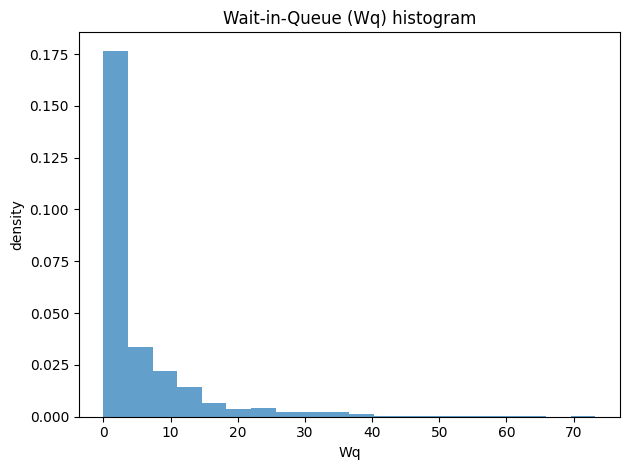

In [ ]:
plt.figure()
plt.hist(res['waiting_time'], bins=20, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Wait-in-Queue (Wq) histogram")
plt.tight_layout(); plt.show()